# Importing the dataset


In [1]:
from __future__ import unicode_literals
import hazm
import numpy as np
# import tensorflow as tf
import pandas as pd
from collections import Counter
import csv, re, pickle

# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Flatten
# import numpy as np
# from keras.utils import to_categorical
# import re
# from utils import words_list, stopwords_list
# from stopping_utility import *
# import nltk
# import wapiti

from colorama import Back, Fore, Style
import time

import matplotlib.pyplot as plt


from os import path
from persian_wordcloud.wordcloud import PersianWordCloud, add_stop_words
from wordcloud import STOPWORDS as EN_STOPWORDS
from wordcloud_fa import WordCloudFa

from sklearn.feature_extraction.text import CountVectorizer
import re
from matplotlib import font_manager as fm, rcParams

import seaborn as sns
sns.set()

# from sklearn import metrics
# import sklearn.metrics as sm
# from sklearn.neighbors import NearestNeighbors
# from sklearn.cluster import Birch
# from sklearn import manifold
# import pyclustering as pyclus

In [2]:
data = pd.read_csv('news_202010261937.csv')
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'news_202010261937.csv'

In [3]:
Counter(data['genre'])

Counter({'politics': 23491,
         'economy': 15694,
         'Undefined': 1957,
         'recreation': 198,
         'good': 342})

In [4]:
list(data[data['genre']=='good']['title'])[3]

'استارت\u200cآپ مشهدی\u200cها برای عدالت\u200cخواهی!'

In [5]:
news = list(data[data['genre']=='economy']['body'])

# news

In [6]:
# i = 0
# for rev in news:
#     if type(rev) == float:
#         print(rev,i)
#     i += 1
# news[658]

In [7]:
news = pd.DataFrame(news)
news.rename(columns={0:'body'} , inplace=True)
news.head()

,body
0,به گزارش گروه اقتصاد بین‌الملل فارس به نقل از ...
1,به گزارش گروه اقتصاد بین‌الملل فارس به نقل از ...
2,به گزارش خبرگزاری فارس به نقل از روابط عمومی و...
3,به گزارش خبرگزاری فارس، شبکه تحلیلگران اقتصاد ...
4,به گزارش خبرنگار اقتصادی خبرگزاری فارس، بر اسا...


# Preliminary text exploration

## Fetch word count for each abstract

In [8]:
#Fetch wordcount for each abstract
news['word_count'] = news['body'].apply(lambda x: len(str(x).split(" ")))
news[['body','word_count']].head()

,body,word_count
0,به گزارش گروه اقتصاد بین‌الملل فارس به نقل از ...,425
1,به گزارش گروه اقتصاد بین‌الملل فارس به نقل از ...,364
2,به گزارش خبرگزاری فارس به نقل از روابط عمومی و...,147
3,به گزارش خبرگزاری فارس، شبکه تحلیلگران اقتصاد ...,724
4,به گزارش خبرنگار اقتصادی خبرگزاری فارس، بر اسا...,601


In [10]:
# news['body']

In [11]:
##Descriptive statistics of word counts
news.word_count.describe()

count    15694.000000
mean       510.806168
std        558.083765
min         33.000000
25%        214.250000
50%        349.000000
75%        619.000000
max      27379.000000
Name: word_count, dtype: float64

In [12]:
sum(news['body'].isna())

0

## cleaning data from none texts, digits, and ...

In [13]:
RE_USELESS = r'[^\w]'  # remove useless characters
RE_DIGIT = r"^\d+\s|\s\d+\s|\s\d+$"  # remove digits
RE_SPACE = r'\s+'  # remove space
RE_EMAILS = r'[\w\.-]+@[\w\.-]+'
RE_URLS = r'http\S+'
RE_WWW = r'www\S+'


def clean_all_save(document, save_file_path):
    """
    this function generate raw persian text, it remove non-persian character
    and all numbers and symbols
    :param document:
    :param save_file_path:
    :return:
    """
    with open(save_file_path, 'w') as output:
        for sentence in document:
            sentence = clean_sentence(sentence)
            output.write(sentence + '\n')
    return None


# def clean_all(document, doc_pattern=r'<TEXT>(.*?)</TEXT>'):
#     """
#     clean text like hamshahri, irBlogs, and other Treck format
#     :param document:
#     :param doc_pattern:
#     :return:
#     """
#     clean = ''
#     document = re.findall(doc_pattern, document, re.DOTALL)
#     for sentence in document:
#         sentence = clean_sentence(sentence)
#         clean += ' \n' + sentence
#     return clean


def clean_sentence(sentence):
    sentence = re.sub(r'[^\u0621-\u06ff]', ' ', sentence)
    sentence = arToPersianChar(sentence)
    sentence = arToPersianNumb(sentence)
    sentence = faToEnglishNumb(sentence)
    sentence = re.sub(r'[0-9]', ' ', sentence)
    sentence = re.sub(RE_WWW, r' ', sentence)
    sentence = re.sub(RE_URLS, r' ', sentence)
    sentence = re.sub(RE_EMAILS, r' ', sentence)
    sentence = re.sub(RE_USELESS, r' ', sentence)
    sentence = re.sub(RE_DIGIT, r' ', sentence)
    sentence = re.sub(RE_SPACE, r' ', sentence)
    sentence = re.sub(r'[a-zA-Z]', ' ', sentence)
    return sentence


def arToPersianNumb(number):
    dic = {
        '١': '۱',
        '٢': '۲',
        '٣': '۳',
        '٤': '۴',
        '٥': '۵',
        '٦': '۶',
        '٧': '۷',
        '٨': '۸',
        '٩': '۹',
        '٠': '۰',
    }
    return multiple_replace(dic, number)


def arToPersianChar(userInput):
    dic = {
        'ك': 'ک',
        'دِ': 'د',
        'بِ': 'ب',
        'زِ': 'ز',
        'ذِ': 'ذ',
        'شِ': 'ش',
        'سِ': 'س',
        'ى': 'ی',
        'ي': 'ی'
    }
    return multiple_replace(dic, userInput)


def faToEnglishNumb(number):
    dic = {
        '۰': '0',
        '۱': '1',
        '۲': '2',
        '۳': '3',
        '۴': '4',
        '۵': '5',
        '۶': '6',
        '۷': '7',
        '۸': '8',
        '۹': '9',
    }
    return multiple_replace(dic, number)


def multiple_replace(dic, text):
    pattern = "|".join(map(re.escape, dic.keys()))
    return re.sub(pattern, lambda m: dic[m.group()], str(text))

In [14]:
def clean_all(document):
    clean = ''
    for sentence in document:
        sentence = clean_sentence(sentence)
        clean += sentence
    return clean

In [15]:
stopwords = list(pd.read_csv('STOPWORDS.csv',header=None)[0])
# stopwords

In [34]:
    
j = k = i = 0
news1 = []
# labels1 = []
# labels1 = list(labels.copy())
normalizer = hazm.Normalizer()
for review in news['body']:
    sentences = normalizer.normalize(clean_all(review))
    ##Convert to list from string
    text = hazm.word_tokenize(sentences)
    ##Stemming
#     ps=PorterStemmer()
    #Lemmatisation
    lem = hazm.Lemmatizer()
    text = [lem.lemmatize(word).split('#')[0] for word in text if not word in stopwords ] 
    text = " ".join(text)
 
    news1.append(text)
    
#     for j in range(len(sentences)):
#         labels1.insert(i + k, labels[i])
#         k += 1
    i += 1

In [36]:
news1[0]

'گزارش گروه اقتصاد الملل فارس نقل رویترز کشتی فله ایران محموله اوره برزیل قرار محموله ذرت ایران برگردند سوخت ماند زیرا شرکت دولت پتروبراس فروش سوخت بانکر علت تحریم آمریکا خوددار کرد آمار رهیاب کشتی داد کشتی مدل پاناماگذر کشتی عبور کانال پاناما دلربا گنج نزدیک بندر ایمبیتوبا جنوب برزیل لنگر انداخت قرار مسیر مشابه کشتی باوند ترمه مشکل سوخت کشتی مالکیت دولت ایران قرار تحریم قرار تامین اصل سوخت بانکر برزیل شرکت ترنس پترو شعبه پتروبراس شرکت فروش سوخت پتروبراس تنبیه آمریکا فعالیت هایش کشور مواجه کشتی کشتی پنجم دریابار موفق ترک برزیل محموله ذرت مسیر تجار دولت ایران دنبال بازار محصولات پتروشیمی جبران فروش نفت منبع صنعتی کشتیرانی دولت ایران ریسک کرد تمام کشتی دانست قادر سوخت مجدد بازگشت فرستاد علی رغم بیانیه پتروبراس کرد شرکت توانست کشتی سوخت فروخت منبع صنعتی انحصار سوختگیری مجدد بنادر برزیل اختیار شرکت دولت کشتی دریابار اوره برزیل آورد مشخص سوخت بازگشت تهیه کرد اساس آمار رهیاب کشتی کشتی نزدیک آفریقا جنوبی پتروبراس موضع تایید شرکت ریسک قرارداد بستن کشتی تحریم مسئولیت شرکت صادرکننده پتروبراس روی

## saving news to file

In [37]:

# data['body'][data['genre']=='economy'] = news1
# data.to_excel("PreprocessedNews_economy.xlsx", index=False)

In [2]:
economydata = data[data['genre']=='economy']
economydata['body'] = news1
economydata.to_excel("Preprocessed_via_HAZM_News_economy.xlsx", index=False)
# del data

NameError: name 'data' is not defined

In [39]:
# economydata.to_excel("PreprocessedNews_economy.xlsx", index=False)

### Preprocess finished

In [3]:
economydata = pd.read_excel("Preprocessed_via_HAZM_News_economy.xlsx")
reviews1 = list(economydata['body'])

print(len(reviews1))
economydata.head()


15694


,id,created_at,updated_at,deleted_at,code,title,lead,body,genre
0,168316,2020-10-24 13:10:01,2020-10-24 13:10:01,NaN,13980429000996,چهار کشتی ایرانی در انتظار سوخت در بنادر برزیل...,رویترز طی گزارشی نوشت دو کشتی دیگر ایران نیز د...,گزارش گروه اقتصاد الملل فارس نقل رویترز کشتی ف...,economy
1,168318,2020-10-24 13:10:03,2020-10-24 13:10:03,NaN,13980429001007,نگرانی تجار برزیلی از خراب شدن تجارت با ایران/...,درحالی‌که رئیس‌جمهور برزیل تلاش می‌کند با جلب ...,گزارش گروه اقتصاد الملل فارس نقل رویترز ژائیر ...,economy
2,168335,2020-10-24 13:10:13,2020-10-24 13:10:13,NaN,13980429001089,بیات عضو هیئت مدیره شرکت ملی صنایع پتروشیمی شد,وزیر نفت در حکمی، عبدالحسین بیات را به مدت سه ...,گزارش خبرگزاری فارس نقل روابط عموم وزارت نفت و...,economy
3,168366,2020-10-24 13:10:30,2020-10-24 13:10:30,NaN,13980429001047,ضرورت راه اندازی پیام‌رسان مالی جایگزین سوئیفت...,در بخشی از گزارش شبکه تحلیلگران اقتصاد مقاومتی...,گزارش خبرگزاری فارس شبکه تحلیلگر اقتصاد مقاومت...,economy
4,170673,2020-10-24 13:29:26,2020-10-24 13:29:26,NaN,13980431000516,افزایش 3386 واحدی شاخص بورس تهران,شاخص کل بورس اوراق بهادار تهران در پایان معامل...,گزارش خبرنگار اقتصاد خبرگزاری فارس اساس اطلاعا...,economy


In [4]:
type(reviews1)

list

## Most common and uncommon words

In [5]:
#Identify common words
freq = pd.Series(' '.join(reviews1).split()).value_counts()
f = list(pd.DataFrame(freq).index)
# f

In [6]:
#Identify uncommon words
freq1 =  pd.Series(' '.join(reviews1).split()).value_counts()[-20:]
freq1

کاتمان             1
بصضی               1
تحم                1
ترنچر              1
اقتصاددر           1
گلدر               1
انصرف              1
شناوردارها         1
ونگهداری           1
شهرسای             1
بپیماید            1
هویکو              1
گپهارت             1
نفتیران            1
اندوهگین           1
وخسارت             1
دیگرنیزحایزتوجه    1
یاچنگ              1
کامترد             1
تبعیدگاه           1
dtype: int64

## Deleting stop words

In [7]:
stop_words = pd.read_csv('STOPWORDS.csv',header=None)
len(set(list(stop_words[0])))

781

In [8]:
# list(stop_words[0])

In [9]:
#Word cloud for English and Persian

#!/usr/bin/env python
"""
Minimal Example
===============
Generating a square wordcloud from the US constitution using default arguments.
"""
# Add another stopword

# stopwords = add_stop_words(f[0:250])
stopwords = add_stop_words(['میشه'])
stopwords |= EN_STOPWORDS
print(len(stopwords))
stopwords |= set(list(stop_words[0]))
stopwords |= set(['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll',
                  'mustn', 're',
                  'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn',
                  'اثر', 'البت', 'بالای', 'تول'
                  , 'توی', 'تی', 'جلوی', 'حدود', 'خارج', 'دنبال', 'رسد', 'رود', 'سری','میشه', 'جواب بدین',
                  'جواب بدید', 'میگه', 'اون','بدید', 'بدین', 'جواب','سلام',
                  'سمت', 'ضد', 'طبق', 'عقب'
                  , 'عل', 'قصد', 'مد', 'نزد', 'نزدیک', 'وسط', 'پاعین', 'ﺮﺗ', 'ﺱﺎﺳﺍﺮﺑ', 'ﺶﺷ', 'ﻪﺘﺷﺍﺪﻧ'])
len(stopwords)

669


1418

In [9]:
# stopwords = add_stop_words(['میشه'])
# stopwords

In [10]:
stopwords1 = stopwords.copy()
for st in stopwords1:
    if type(st)==int or type(st)==float or type(st)==type(True):
        stopwords.remove(st)
        print(st)
del stopwords1
len(stopwords)
stopwords = list(stopwords)

In [11]:
# print(stopwords)

In [12]:
# # Python program for insert and search 
# # operation in a Trie 

# class TrieNode: 

#     # Trie node class 
#     def __init__(self): 
#         self.children = [None]*80000

#         # isEndOfWord is True if node represent the end of the word 
#         self.isEndOfWord = False

# class Trie: 

#     # Trie data structure class 
#     def __init__(self): 
#         self.root = self.getNode() 

#     def getNode(self): 

#         # Returns new trie node (initialized to NULLs) 
#         return TrieNode() 

#     def _charToIndex(self,ch): 

#         # private helper function 
#         # Converts key current character into index 
#         # use only 'a' through 'z' and lower case 

#         return ord(ch)-ord('!') 


#     def insert(self,key): 

#         # If not present, inserts key into trie 
#         # If the key is prefix of trie node, 
#         # just marks leaf node 
#         pCrawl = self.root 
#         length = len(key) 
#         for level in range(length): 
#             index = self._charToIndex(key[level]) 

#             # if current character is not present 
#             if not pCrawl.children[index]: 
#                 pCrawl.children[index] = self.getNode() 
#             pCrawl = pCrawl.children[index] 

#         # mark last node as leaf 
#         pCrawl.isEndOfWord = True

#     def search(self, key): 

#         # Search key in the trie 
#         # Returns true if key presents 
#         # in trie, else false 
#         pCrawl = self.root 
#         length = len(key) 
#         for level in range(length): 
#             index = self._charToIndex(key[level]) 
#             if not pCrawl.children[index]: 
#                 return False
#             pCrawl = pCrawl.children[index] 

#         return pCrawl != None and pCrawl.isEndOfWord 


In [13]:
# i = 0
# keys = list(stopwords)

# # Trie object 
# t = Trie() 

# # Construct trie 
# for key in keys: 
#     t.insert(key) 

# # reviews = reviews1.copy()
# # for rev in reviews1:
# # #     rev = rev.replace('\u200c',' ')
# # #         rev = rev.replace('\u200f',' ')
# # #         rev = re.sub(r'[^a-zA-Z0-9آ-ی۰-۹ ]', ' ', rev)
# #     words = rev.split(' ')

# #     words1 = words.copy()
# #     for w in words:
# #         if w == '':
# #             words1.remove(w)
# #             continue
# #         if t.search(w):
# #             words1.remove(w)

# #     words = words1
# #     text = ''
# #     for w in words:
# #         text += w + ' '
# #     reviews[i] = text
# #     i += 1

# # reviews1 = reviews.copy()
# # del reviews

In [14]:
# ord('!')-ord('!')

In [15]:
# # Input keys (use only 'a' through 'z' and lower case) 
# keys = list(stopwords.loc[:,0])

# output = ["Not present in trie", 
#         "Present in trie"] 

# # Trie object 
# t = Trie() 

# # Construct trie 
# for key in keys: 
#     t.insert(key) 


# print("{} ---- {}".format("از",output[t.search("از")])) 



In [16]:
# ### stopword deletion Testing
# rev = reviews1[0]

# print(rev)
# #rev = rev.replace('\u200c',' ')
# rev = rev.replace('\u200f',' ')
# rev = re.sub(r'[^a-zA-Z0-9آ-ی۰-۹ ]', ' ', rev)
# rev.split(' ')
# words = rev.split()

# words1 = words.copy()
# for w in words:
#     if w == '':
#         words1.remove(w)
#         continue
#     if t.search(w):
#         words1.remove(w)

# words = words1
# text = ''
# for w in words:
#     text += w + ' '
# text


In [17]:
# keys

In [18]:
# i = 0
# for rev in reviews1:
#     if type(rev) == float:
#         print(rev,i)
#     i += 1

### Stop word deleting finished

In [19]:
## If you wish to withdraw stopword deletion, uncomment the below line, and run it.
# reviews = reviews1

In [20]:
# #cleaning dataset
# #word_tokenize
# words=[]
# all_text = ''
# # stemmer = Stemmer()
# for i in range (len(reviews)):
#     text = reviews[i]
# #     text = text.replace('\u200c',' ')
#     text = text.replace('\u200f',' ')
#     text = re.sub(r'[^a-zA-Z0-9آ-ی۰-۹ ]', ' ', text)
#     all_text += text
#     all_text += ' '
#     wordsInText = text.split()
#     for word in wordsInText:
#         if word != ' ' or word != '':
#             words.append(word)
# len(words)

In [11]:
i = 0
nulltextindex = []
holdingCorpus = reviews1.copy()
corpus1 = reviews1.copy()
for rev in corpus1:
#     rev = rev.replace('\u200c',' ')
    rev = rev.replace('\u200f',' ')
    rev = re.sub(r'[^a-zA-Zآ-ی]', ' ', rev)
    rev.split(' ')
    words = rev.split(' ')

    words1 = words.copy()
    for w in words:
        if w == ''or type(w)==int or type(w)==float or type(w)==bool:
            words1.remove(w)
            continue
        if w in stopwords:
            words1.remove(w)

    words = words1.copy()
    text = ''
    for w in words:
        text += w + ' '
    corpus1[i] = text
    if type(text)!= str or len(text)==0 :
        nulltextindex.append(i)
    i += 1
corpus = corpus1.copy()
del corpus1
nulltextindex

[]

In [ ]:
text = ''
for tex in corpus:
    text = text+ '\n' +tex

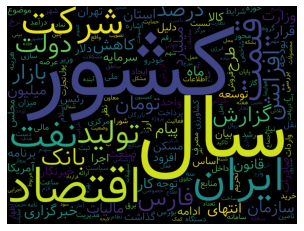

In [64]:
wodcloud = WordCloudFa(no_reshape=False, persian_normalize=True, include_numbers=False,
                       collocations=False, width=1200, height=900)

wc = wodcloud.generate(text)
image = wc.to_image()
image.show()
image.save('wordcloud.png')

print(wc)
fig = plt.figure(1)

plt.imshow(wc)
plt.axis('off')
# plt.show()

In [23]:
CountVec = CountVectorizer(max_df=0.8, stop_words=stopwords, max_features=100000, ngram_range=(1, 3))
X = CountVec.fit_transform(corpus)

In [24]:
X

<15694x100000 sparse matrix of type '<class 'numpy.int64'>'
	with 4187850 stored elements in Compressed Sparse Row format>

In [25]:
len(list(CountVec.vocabulary_.keys()))

100000

      Word   Freq
0     کشور  51824
1      سال  40309
2   اقتصاد  38265
3    ایران  32609
4     شرکت  30970
5      نفت  30048
6     قیمت  27608
7    تولید  26792
8     دولت  25741
9     فارس  24772
10  افزایش  24337
11    بانک  24012
12   گزارش  23551
13   بازار  22760
14    درصد  22429
15   تومان  20171
16  سازمان  19531
17    کاهش  19173
18    پیام  16912
19     کار  16335


[Text(0, 0, 'کشور'),
 Text(1, 0, 'سال'),
 Text(2, 0, 'اقتصاد'),
 Text(3, 0, 'ایران'),
 Text(4, 0, 'شرکت'),
 Text(5, 0, 'نفت'),
 Text(6, 0, 'قیمت'),
 Text(7, 0, 'تولید'),
 Text(8, 0, 'دولت'),
 Text(9, 0, 'فارس'),
 Text(10, 0, 'افزایش'),
 Text(11, 0, 'بانک'),
 Text(12, 0, 'گزارش'),
 Text(13, 0, 'بازار'),
 Text(14, 0, 'درصد'),
 Text(15, 0, 'تومان'),
 Text(16, 0, 'سازمان'),
 Text(17, 0, 'کاهش'),
 Text(18, 0, 'پیام'),
 Text(19, 0, 'کار')]

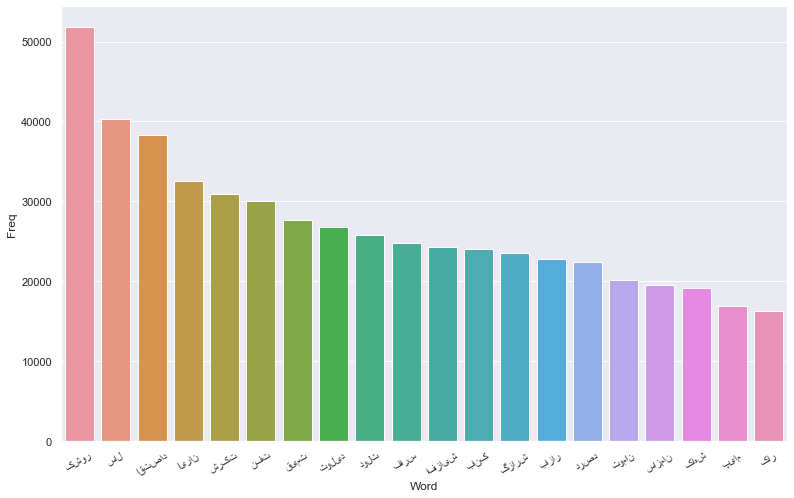

In [26]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]


#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)
#Barplot of most freq words
sns.set(rc={'figure.figsize':(13, 8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

            Bi-gram   Freq
0       انتهای پیام  15619
1     خبرگزاری فارس  15325
2    خبرنگار اقتصاد   9771
3   اقتصاد خبرگزاری   8297
4     گزارش خبرنگار   7867
5     میلیارد تومان   7618
6        بانک مرکزی   7366
7      سرمایه گذاشت   5763
8          فارس نقل   5092
9       افزایش قیمت   3442
10     میلیارد دلار   3428
11   گزارش خبرگزاری   3389
12     میلیون تومان   3266
13          حمل نقل   3060
14        نفت ایران   3050
15         سال جاری   2905
16     اقتصاد الملل   2902
17     جهاد کشاورزی   2696
18         شرکت ملی   2615
19       رئیس جمهور   2486


[Text(0, 0, 'انتهای پیام'),
 Text(1, 0, 'خبرگزاری فارس'),
 Text(2, 0, 'خبرنگار اقتصاد'),
 Text(3, 0, 'اقتصاد خبرگزاری'),
 Text(4, 0, 'گزارش خبرنگار'),
 Text(5, 0, 'میلیارد تومان'),
 Text(6, 0, 'بانک مرکزی'),
 Text(7, 0, 'سرمایه گذاشت'),
 Text(8, 0, 'فارس نقل'),
 Text(9, 0, 'افزایش قیمت'),
 Text(10, 0, 'میلیارد دلار'),
 Text(11, 0, 'گزارش خبرگزاری'),
 Text(12, 0, 'میلیون تومان'),
 Text(13, 0, 'حمل نقل'),
 Text(14, 0, 'نفت ایران'),
 Text(15, 0, 'سال جاری'),
 Text(16, 0, 'اقتصاد الملل'),
 Text(17, 0, 'جهاد کشاورزی'),
 Text(18, 0, 'شرکت ملی'),
 Text(19, 0, 'رئیس جمهور')]

findfont: Font family ['XB Niloofar'] not found. Falling back to DejaVu Sans.


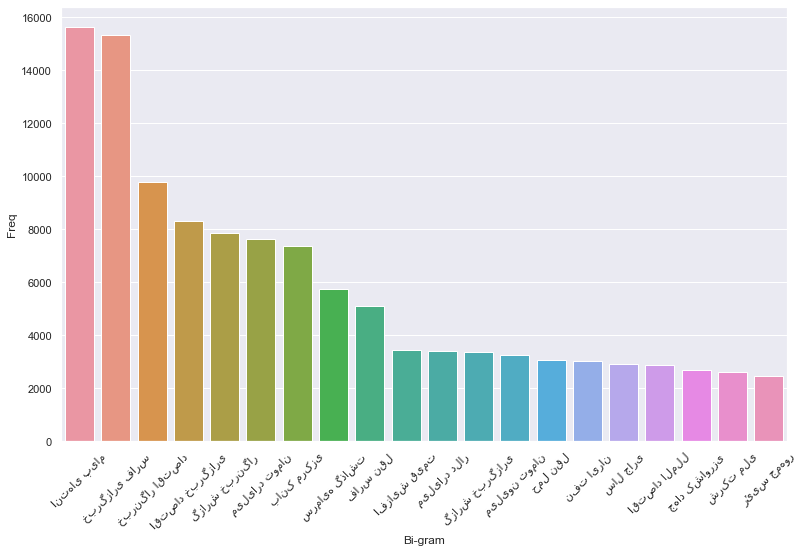

In [27]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45, name = 'XB Niloofar')